## Imports
Some unnecessary for now imports here that may be useful later

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
import torchvision.transforms as T
from torch.utils.data import Dataset
from torchvision.io import read_image

## Dataloader
Dataloader for the lung dataset

In [2]:
class lung_dataset(Dataset):
    def __init__(self, data_path, transform, train_test = 'train'):
        self.im_path = data_path + '/images/images/' #Path to images
        self.meta_csv = pd.read_csv(data_path + '/metadata_{}.csv'.format(train_test)) #Path to metadata
        self.transform = transform #Predefined transforms

        #Get dictionaries to map classes to numbers and vice versa
        self.label_to_class = self.meta_csv['Finding Labels'].drop_duplicates().reset_index().to_dict()['Finding Labels']
        self.class_to_label = dict((v,k) for k,v in self.label_to_class.items())

    def __len__(self):
        return len(self.meta_csv)

    def __getitem__(self, idx):
        im_data = self.meta_csv.iloc[idx]

        im = Image.open(self.im_path + im_data['Image Index'])
        im = self.transform(im)

        label = self.class_to_label[im_data['Finding Labels']]

        return im, label


## Create Datasets/Dataloaders

In [3]:
train_transform = T.Compose([T.ToTensor()])

#Dataset train_test can be: 'train' or 'test'
#Val data comes from splitting train set
dataset = lung_dataset('./CXR8', train_transform, 'train')

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

train_loader = dataloader.DataLoader(train_dataset, shuffle = True, batch_size = 32)
test_loader = dataloader.DataLoader(val_dataset, shuffle = False, batch_size = 32)

print(len(dataset))
print(len(train_dataset))
print(len(val_dataset))

73471
58776
14695


## Display output from dataloader

Label: 3  Class:  Nodule


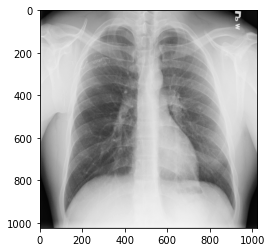

In [4]:
dataiter = iter(train_loader)

images, labels = dataiter.next()

plt.imshow(images[0].permute(1, 2, 0)/255, cmap='gray')
print("Label:", labels[0].item(), " Class: ", dataset.label_to_class[labels[0].item()])
